In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [2]:
(x_train ,y_train),(x_test, y_test) = keras.datasets.fashion_mnist.load_data()
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)
y_train shape: (60000,)


In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
X_train_norm = x_train.astype('float32') / 255.0
X_test_norm = x_test.astype('float32') / 255.0

In [5]:
from sklearn.model_selection import train_test_split
x_train_final, x_val, y_train_final, y_val = train_test_split(X_train_norm, y_train, test_size=0.2, random_state=SEED, stratify=y_train)
print("Training set:", x_train_final.shape, y_train_final.shape)
print("Validation set:", x_val.shape, y_val.shape)

Training set: (48000, 28, 28) (48000,)
Validation set: (12000, 28, 28) (12000,)


In [8]:
# for mlp
x_train_mlp = x_train_final.reshape((x_train_final.shape[0], -1))
x_val_mlp = x_val.reshape((x_val.shape[0], -1))
x_test_mlp = X_test_norm.reshape((X_test_norm.shape[0], -1))
# for cnn
x_train_cnn = x_train_final[...,np.newaxis]
x_val_cnn = x_val[..., np.newaxis]
x_test_cnn = X_test_norm[..., np.newaxis]

In [9]:
input_shape_mlp = x_train_mlp.shape[1]
input_shape_cnn = x_train_cnn.shape[1:]
print('MLP input dim:', input_shape_mlp)
print('CNN input shape:', input_shape_cnn)

MLP input dim: 784
CNN input shape: (28, 28, 1)


In [11]:
def plot_history(history, title_prefix=''):
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))
  axes[0].plot(history.history['accuracy'], label='train')
  axes[0].plot(history.history['val_accuracy'], label='val')
  axes[0].set_title(f'{title_prefix} Accuracy')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Accuracy')
  axes[0].legend()
  axes[1].plot(history.history['loss'], label='train')
  axes[1].plot(history.history['val_loss'], label='val')
  axes[1].set_title(f'{title_prefix} Loss')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Loss')
  axes[1].legend()

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [13]:
def show_sample_predictions(model, x, y_true, is_cnn=False, n=12):
  # Show n sample predictions from x
  idxs = np.random.choice(range(x.shape[0]), size=n, replace=False)
  samples = x[idxs]
  if is_cnn:
   preds = model.predict(samples)
  else:
   preds = model.predict(samples.reshape((n, -1)))
   pred_labels = np.argmax(preds, axis=1)


  cols = 6
  rows = int(np.ceil(n/cols))
  plt.figure(figsize=(cols*2, rows*2))
  for i, (img_idx, pl) in enumerate(zip(idxs, pred_labels)):
   plt.subplot(rows, cols, i+1)
  if is_cnn:
   plt.imshow(samples[i].squeeze(), cmap='gray')
  else:
  # reshape back to 28x28
    plt.imshow(samples[i].reshape(28,28), cmap='gray')
    title = f'{class_names[pl]}\n(true: {class_names[y_true[img_idx]]})'
    plt.title(title, fontsize=8)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [14]:
def build_mlp(input_dim, num_classes=10):
  model = keras.Sequential([
  layers.Input(shape=(input_dim,)),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
  ], name='MLP_FashionMNIST')
  return model

In [15]:
mlp = build_mlp(input_shape_mlp)
mlp.summary()

Model: "MLP_FashionMNIST"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
mlp.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])


checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
mlp_ckpt = os.path.join(checkpoint_dir, 'mlp_best.h5')


callbacks = [
keras.callbacks.ModelCheckpoint(mlp_ckpt, save_best_only=True, monitor='val_accuracy', mode='max'),
keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
]


history_mlp = mlp.fit(
x_train_mlp, y_train_final,
validation_data=(x_val_mlp, y_val),
epochs=50,
batch_size=128,
callbacks=callbacks,
verbose=2
)

Epoch 1/50


375/375 - 6s - 15ms/step - accuracy: 0.7709 - loss: 0.6330 - val_accuracy: 0.8474 - val_loss: 0.4112
Epoch 2/50


375/375 - 4s - 11ms/step - accuracy: 0.8340 - loss: 0.4505 - val_accuracy: 0.8624 - val_loss: 0.3760
Epoch 3/50


375/375 - 5s - 14ms/step - accuracy: 0.8461 - loss: 0.4147 - val_accuracy: 0.8732 - val_loss: 0.3464
Epoch 4/50


375/375 - 4s - 12ms/step - accuracy: 0.8558 - loss: 0.3886 - val_accuracy: 0.8762 - val_loss: 0.3411
Epoch 5/50
375/375 - 4s - 12ms/step - accuracy: 0.8618 - loss: 0.3722 - val_accuracy: 0.8762 - val_loss: 0.3296
Epoch 6/50


375/375 - 4s - 12ms/step - accuracy: 0.8683 - loss: 0.3569 - val_accuracy: 0.8809 - val_loss: 0.3249
Epoch 7/50


375/375 - 4s - 11ms/step - accuracy: 0.8704 - loss: 0.3507 - val_accuracy: 0.8814 - val_loss: 0.3287
Epoch 8/50


375/375 - 4s - 12ms/step - accuracy: 0.8733 - loss: 0.3380 - val_accuracy: 0.8842 - val_loss: 0.3171
Epoch 9/50


375/375 - 4s - 12ms/step - accuracy: 0.8778 - loss: 0.3284 - val_accuracy: 0.8862 - val_loss: 0.3099
Epoch 10/50


375/375 - 4s - 11ms/step - accuracy: 0.8780 - loss: 0.3245 - val_accuracy: 0.8866 - val_loss: 0.3163
Epoch 11/50


375/375 - 5s - 12ms/step - accuracy: 0.8822 - loss: 0.3138 - val_accuracy: 0.8879 - val_loss: 0.3090
Epoch 12/50


375/375 - 5s - 12ms/step - accuracy: 0.8829 - loss: 0.3111 - val_accuracy: 0.8887 - val_loss: 0.3084
Epoch 13/50


375/375 - 4s - 11ms/step - accuracy: 0.8854 - loss: 0.3043 - val_accuracy: 0.8898 - val_loss: 0.3077
Epoch 14/50
375/375 - 5s - 12ms/step - accuracy: 0.8853 - loss: 0.3029 - val_accuracy: 0.8882 - val_loss: 0.3057
Epoch 15/50
375/375 - 4s - 11ms/step - accuracy: 0.8879 - loss: 0.2964 - val_accuracy: 0.8888 - val_loss: 0.3101
Epoch 16/50


375/375 - 4s - 11ms/step - accuracy: 0.8867 - loss: 0.2941 - val_accuracy: 0.8935 - val_loss: 0.3040
Epoch 17/50
375/375 - 4s - 12ms/step - accuracy: 0.8929 - loss: 0.2843 - val_accuracy: 0.8914 - val_loss: 0.3048
Epoch 18/50
375/375 - 4s - 11ms/step - accuracy: 0.8930 - loss: 0.2776 - val_accuracy: 0.8906 - val_loss: 0.3068
Epoch 19/50
375/375 - 5s - 12ms/step - accuracy: 0.8945 - loss: 0.2803 - val_accuracy: 0.8925 - val_loss: 0.2964
Epoch 20/50
375/375 - 4s - 11ms/step - accuracy: 0.8949 - loss: 0.2758 - val_accuracy: 0.8912 - val_loss: 0.3036
Epoch 21/50
375/375 - 4s - 11ms/step - accuracy: 0.8968 - loss: 0.2722 - val_accuracy: 0.8913 - val_loss: 0.3057
Epoch 22/50


375/375 - 5s - 12ms/step - accuracy: 0.8967 - loss: 0.2669 - val_accuracy: 0.8954 - val_loss: 0.2955
Epoch 23/50


375/375 - 4s - 10ms/step - accuracy: 0.8985 - loss: 0.2661 - val_accuracy: 0.8964 - val_loss: 0.2929
Epoch 24/50
375/375 - 4s - 11ms/step - accuracy: 0.9005 - loss: 0.2605 - val_accuracy: 0.8939 - val_loss: 0.2977
Epoch 25/50
375/375 - 4s - 12ms/step - accuracy: 0.9022 - loss: 0.2576 - val_accuracy: 0.8923 - val_loss: 0.3072
Epoch 26/50
375/375 - 4s - 10ms/step - accuracy: 0.9018 - loss: 0.2565 - val_accuracy: 0.8955 - val_loss: 0.2974
Epoch 27/50


375/375 - 4s - 11ms/step - accuracy: 0.9049 - loss: 0.2494 - val_accuracy: 0.8972 - val_loss: 0.3043
Epoch 28/50


375/375 - 4s - 12ms/step - accuracy: 0.9040 - loss: 0.2546 - val_accuracy: 0.8978 - val_loss: 0.2940
Epoch 29/50
375/375 - 4s - 10ms/step - accuracy: 0.9053 - loss: 0.2501 - val_accuracy: 0.8955 - val_loss: 0.2993
Epoch 30/50
375/375 - 4s - 12ms/step - accuracy: 0.9075 - loss: 0.2432 - val_accuracy: 0.8966 - val_loss: 0.2985
Epoch 31/50
375/375 - 4s - 11ms/step - accuracy: 0.9075 - loss: 0.2432 - val_accuracy: 0.8957 - val_loss: 0.3011
Epoch 32/50
375/375 - 4s - 10ms/step - accuracy: 0.9090 - loss: 0.2402 - val_accuracy: 0.8971 - val_loss: 0.3061
Epoch 33/50


375/375 - 4s - 12ms/step - accuracy: 0.9099 - loss: 0.2394 - val_accuracy: 0.8989 - val_loss: 0.2923
Epoch 34/50
375/375 - 4s - 10ms/step - accuracy: 0.9082 - loss: 0.2374 - val_accuracy: 0.8986 - val_loss: 0.2949
Epoch 35/50
375/375 - 4s - 10ms/step - accuracy: 0.9103 - loss: 0.2340 - val_accuracy: 0.8953 - val_loss: 0.3061
Epoch 36/50
375/375 - 4s - 12ms/step - accuracy: 0.9115 - loss: 0.2332 - val_accuracy: 0.8979 - val_loss: 0.2995
Epoch 37/50


375/375 - 5s - 12ms/step - accuracy: 0.9111 - loss: 0.2316 - val_accuracy: 0.8996 - val_loss: 0.2993
Epoch 38/50
375/375 - 5s - 15ms/step - accuracy: 0.9137 - loss: 0.2273 - val_accuracy: 0.8991 - val_loss: 0.2942
Epoch 39/50


375/375 - 4s - 10ms/step - accuracy: 0.9160 - loss: 0.2230 - val_accuracy: 0.9004 - val_loss: 0.2962
Epoch 40/50


375/375 - 5s - 14ms/step - accuracy: 0.9155 - loss: 0.2225 - val_accuracy: 0.9013 - val_loss: 0.2924
Epoch 41/50
375/375 - 4s - 11ms/step - accuracy: 0.9137 - loss: 0.2216 - val_accuracy: 0.9007 - val_loss: 0.2952
Epoch 42/50
375/375 - 4s - 10ms/step - accuracy: 0.9155 - loss: 0.2218 - val_accuracy: 0.9009 - val_loss: 0.2951
Epoch 43/50
375/375 - 4s - 12ms/step - accuracy: 0.9174 - loss: 0.2172 - val_accuracy: 0.8986 - val_loss: 0.3065
Epoch 44/50


375/375 - 4s - 11ms/step - accuracy: 0.9166 - loss: 0.2172 - val_accuracy: 0.9014 - val_loss: 0.3044
Epoch 45/50


375/375 - 5s - 13ms/step - accuracy: 0.9180 - loss: 0.2145 - val_accuracy: 0.9019 - val_loss: 0.3015
Epoch 46/50
375/375 - 4s - 12ms/step - accuracy: 0.9176 - loss: 0.2163 - val_accuracy: 0.9001 - val_loss: 0.2950
Epoch 47/50


375/375 - 4s - 11ms/step - accuracy: 0.9195 - loss: 0.2117 - val_accuracy: 0.9024 - val_loss: 0.2930
Epoch 48/50
375/375 - 4s - 11ms/step - accuracy: 0.9197 - loss: 0.2089 - val_accuracy: 0.8991 - val_loss: 0.3067
Epoch 49/50
375/375 - 5s - 12ms/step - accuracy: 0.9206 - loss: 0.2070 - val_accuracy: 0.9018 - val_loss: 0.3086
Epoch 50/50
375/375 - 4s - 10ms/step - accuracy: 0.9204 - loss: 0.2068 - val_accuracy: 0.9002 - val_loss: 0.3051


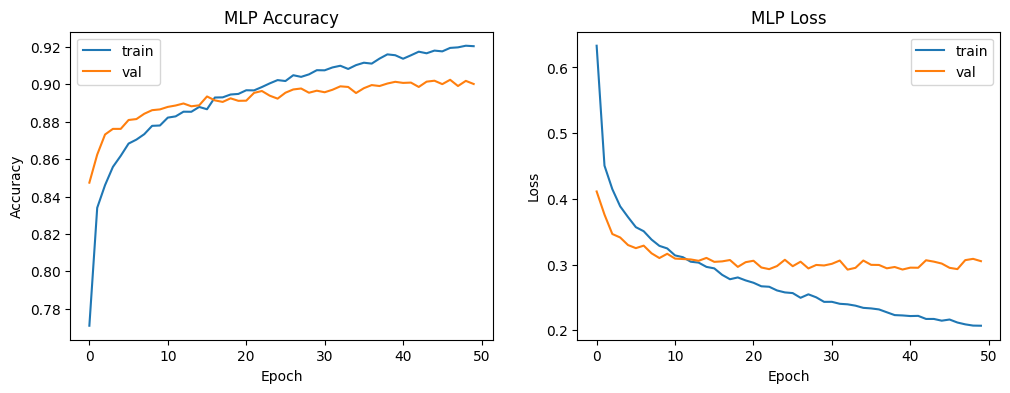

In [17]:
plot_history(history_mlp, title_prefix='MLP')

In [18]:
mlp_eval = mlp.evaluate(x_test_mlp, y_test, verbose=0)
print(f"MLP Test loss: {mlp_eval[0]:.4f}, Test accuracy: {mlp_eval[1]:.4f}")

MLP Test loss: 0.3107, Test accuracy: 0.8965


In [19]:
y_pred_proba = mlp.predict(x_test_mlp)
y_pred = np.argmax(y_pred_proba, axis=1)
print('\nClassification report (MLP):')
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification report (MLP):
              precision    recall  f1-score   support

 T-shirt/top     0.8235    0.8820    0.8518      1000
     Trouser     0.9889    0.9770    0.9829      1000
    Pullover     0.8084    0.8270    0.8176      1000
       Dress     0.8926    0.8980    0.8953      1000
        Coat     0.7926    0.8520    0.8212      1000
      Sandal     0.9867    0.9620    0.9742      1000
       Shirt     0.7849    0.6570    0.7153      1000
     Sneaker     0.9478    0.9630    0.9554      1000
         Bag     0.9819    0.9770    0.9794      1000
  Ankle boot     0.9566    0.9700    0.9633      1000

    accuracy                         0.8965     10000
   macro avg     0.8964    0.8965    0.8956     10000
weighted avg     0.8964    0.8965    0.8956     10000



In [20]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix (rows=true, cols=pred):')
print(cm)

Confusion matrix (rows=true, cols=pred):
[[882   2   9  22   5   0  73   0   7   0]
 [  3 977   0  13   4   0   2   0   1   0]
 [ 18   1 827  13  97   0  43   0   1   0]
 [ 20   8  12 898  43   0  16   0   3   0]
 [  0   0  81  23 852   0  43   0   1   0]
 [  0   0   0   0   0 962   0  23   0  15]
 [143   0  92  30  73   0 657   0   5   0]
 [  0   0   0   0   0   8   0 963   0  29]
 [  4   0   2   7   1   1   3   5 977   0]
 [  1   0   0   0   0   4   0  25   0 970]]


In [23]:
def build_cnn(input_shape, num_classes=10):
  inputs = layers.Input(shape=input_shape)
  x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Flatten()(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dropout(0.4)(x)
  outputs = layers.Dense(num_classes, activation='softmax')(x)
  model = keras.Model(inputs, outputs, name='CNN_FashionMNIST')
  return model


cnn = build_cnn(input_shape_cnn)
cnn.summary()

Model: "CNN_FashionMNIST"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,702,026 (6.49 MB)

 Trainable params: 1,701,578 (6.49 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50


375/375 - 74s - 198ms/step - accuracy: 0.8444 - loss: 0.4512 - val_accuracy: 0.7799 - val_loss: 0.8401
Epoch 2/50


375/375 - 82s - 220ms/step - accuracy: 0.8982 - loss: 0.2807 - val_accuracy: 0.8982 - val_loss: 0.2897
Epoch 3/50


375/375 - 72s - 191ms/step - accuracy: 0.9140 - loss: 0.2306 - val_accuracy: 0.9041 - val_loss: 0.2896
Epoch 4/50


375/375 - 81s - 215ms/step - accuracy: 0.9256 - loss: 0.1973 - val_accuracy: 0.9185 - val_loss: 0.2592
Epoch 5/50
375/375 - 84s - 223ms/step - accuracy: 0.9359 - loss: 0.1699 - val_accuracy: 0.9089 - val_loss: 0.2719
Epoch 6/50
375/375 - 72s - 193ms/step - accuracy: 0.9438 - loss: 0.1484 - val_accuracy: 0.9127 - val_loss: 0.3177
Epoch 7/50
375/375 - 84s - 223ms/step - accuracy: 0.9491 - loss: 0.1334 - val_accuracy: 0.9171 - val_loss: 0.3006
Epoch 8/50
375/375 - 73s - 196ms/step - accuracy: 0.9568 - loss: 0.1157 - val_accuracy: 0.9166 - val_loss: 0.3095
Epoch 9/50
375/375 - 79s - 211ms/step - accuracy: 0.9584 - loss: 0.1088 - val_accuracy: 0.9107 - val_loss: 0.3583
Epoch 10/50
375/375 - 72s - 191ms/step - accuracy: 0.9606 - loss: 0.1037 - val_accuracy: 0.9153 - val_loss: 0.3605


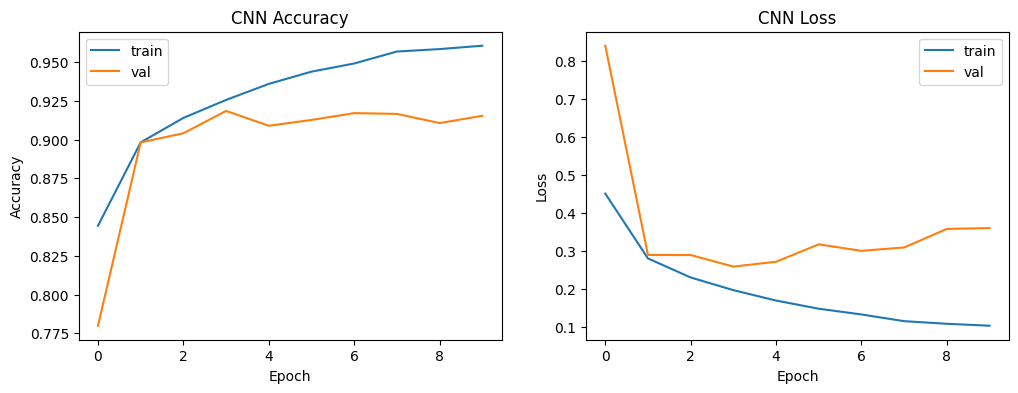

In [24]:
cnn.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])


cnn_ckpt = os.path.join(checkpoint_dir, 'cnn_best.h5')
callbacks_cnn = [
keras.callbacks.ModelCheckpoint(cnn_ckpt, save_best_only=True, monitor='val_accuracy', mode='max'),
keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
]


history_cnn = cnn.fit(
x_train_cnn, y_train_final,
validation_data=(x_val_cnn, y_val),
epochs=50,
batch_size=128,
callbacks=callbacks_cnn,
verbose=2
)


plot_history(history_cnn, title_prefix='CNN')

In [25]:
cnn_eval = cnn.evaluate(x_test_cnn, y_test, verbose=0)
print(f"CNN Test loss: {cnn_eval[0]:.4f}, Test accuracy: {cnn_eval[1]:.4f}")

CNN Test loss: 0.2909, Test accuracy: 0.9103
